In [325]:
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()
pd.set_option('max_columns', None) # see all the columns (max = None)
pd.set_option('max_colwidth', None) # width of the columns
max_rows = 50
pd. set_option('display.max_rows', max_rows) # no limits for rows
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib 
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import networkx as nx
from networkx.algorithms import bipartite
import plotly.express as px

In [315]:
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.3.4


In [2]:
clinical_info = pd.read_csv('./metadata/Clinical_Dictionary.csv')
    # explanations of each files  &   of the mesurement.
    
participant = pd.read_csv('./metadata/aals_participants.csv')
portal = pd.read_csv('./metadata/aals_dataportal_datatable.csv')
files = pd.read_csv('./metadata/aals_released_files.csv') 
    # what can i do with that ??

In [3]:
files = clinical_info['Form_Name'].unique()

clinical_dict = {}

for name in files : 
    clinical_dict[name] = clinical_info[clinical_info.Form_Name == name].iloc[:,1:]
# transorm the clinical information in a true dictionnary, to access the details of each file by a key !

    
# buid a dictionnary with each file name as key, and the corresponding dataset as value.    
clinical_data = {}
for file_name in os.listdir('./metadata/clinical'):
    file = file_name[:-4] # not to have files name with .csv (homogene with the dictionary index !)
    clinical_data[file] = pd.read_csv('./metadata/clinical/'+file_name)
    clinical_data[file].columns = clinical_data[file].columns.str.strip()

In [40]:
portal[['NEFH (SMI32)', 'ISL1', 'NKX6.1', 'TUBB3 (TuJ1)', 's100b', 'Nestin']]

,NEFH (SMI32),ISL1,NKX6.1,TUBB3 (TuJ1),s100b,Nestin
0,63.6,16.039,33.130,78.117,10.458,55.742
1,62.9,10.556,31.805,71.380,36.141,45.230
2,71.9,19.619,40.036,75.562,25.137,45.971
3,52.1,6.333,29.514,63.153,60.533,NaN
4,63.6,1.191,30.105,76.747,2.804,30.693
...,...,...,...,...,...,...
1036,NaN,NaN,NaN,NaN,NaN,NaN
1037,NaN,NaN,NaN,NaN,NaN,NaN
1038,74.2,22.100,31.980,79.720,18.160,40.090
1039,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
for file in os.listdir('./metadata/clinical'):
    print(file[:-4])
# list of the clinical files

AALSDXFX
AALSHXFX
ALSFRS_R
ALS_CBS
ALS_Gene_Mutations
ANSASFD
ANSWER_ALS_Medications_Log
ANSWER_ALS_MobileApp
Ashworth_Spasticity_Scale
Auxiliary_Chemistry
Auxiliary_Chemistry_Labs
Cerebrospinal_Fluid
CNS_Lability_Scale
Demographics
Diaphragm_Pacing_System_Device
DNA_Sample_Collection
Family_History_Log
Feeding_Tube_Placement
Grip_Strength_Testing
Hand_Held_Dynamometry
Medical_History
Mortality
NEUROLOG
NIV_Log
PBMC_Sample_Collection
Permanent_Assisted_Ventilation
Plasma_Sample
Reflexes
Serum_Sample
subjects
Tracheostomy
Vital_Capacity
Vital_Signs


# TABLE

In [49]:
patients = participant[['Participant_ID']]

score_rate = portal[['Participant_ID', 'ALSFRS-R Progression Slope']]

demographics = clinical_data['Demographics'][['Participant_ID','ethnic',
                                      'raceamin', 'raceasn', 'raceblk', 'racenh',
                                      'racewt', 'sex']]
demographics = demographics.replace({2:0})
demog_clean = {'Participant_ID' : demographics.Participant_ID,
               'origin' :demographics.iloc[:,1:7].idxmax(axis = 1),
               'sex' : demographics.sex.replace({1:'male',0:'female'})}
demog_clean = pd.DataFrame(demog_clean)

mutations = clinical_data['ALS_Gene_Mutations'][['Participant_ID',
                                    'ang', 'c9orf72', 'fus', 'mutot',
                                    'progran', 'setx', 'sod1', 'tau',
                                    'tdp43', 'vapb', 'vcp']]

died_als = clinical_data['Mortality'][clinical_data['Mortality'].diedcaus.str.contains('ALS') == True][['Participant_ID']]
died_als['alsdied'] = 1 # 1 if died of ALS causes during the study

table = patients.merge(
    demog_clean, on = 'Participant_ID', how = 'left').merge(
    score_rate, on = 'Participant_ID', how = 'left').merge(
    died_als,on = 'Participant_ID', how = 'left').merge(
    mutations, on = 'Participant_ID', how = 'left')

# left and first on demographics, to have all the patients, ALSO the CTRL !

table = table.replace({2:0})
table = table.fillna(0)

table = table.set_index('Participant_ID')

    # we drop all the 'nd' columns wich are note usefull
# but still very sparse matrix !!

table

,origin,sex,ALSFRS-R Progression Slope,alsdied,ang,c9orf72,fus,mutot,progran,setx,sod1,tau,tdp43,vapb,vcp
Participant_ID,,,,,,,,,,,,,,,
CASE-NEUAA295HHE,racewt,male,-0.6250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CASE-NEUAA599TMX,racewt,female,0.0000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CASE-NEUAB000NKC,racewt,female,-0.5590,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CASE-NEUAC617GR5,raceasn,male,-0.0725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CASE-NEUAD142RRY,racewt,male,0.0000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTRL-NEUZH755EKF,racewt,male,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CTRL-NEUZL045YD3,raceasn,female,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CTRL-NEUZR532AA4,racewt,female,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Exploration of the extension 

> ### Symptoms

> ### Tracheostomy

> ### Permanent Assisted Ventilation

In [87]:
ventilation = clinical_data['Permanent_Assisted_Ventilation'][['Participant_ID','pavyn']]

,Participant_ID,pavyn
0,CASE-NEUAA599TMX,0
1,CASE-NEUAG241NUD,0
2,CASE-NEUAG603XLK,0
3,CASE-NEUAG766ULB,0
4,CASE-NEUAJ481YYX,0
...,...,...
260,CASE-NEUZN936HJ9,0
261,CASE-NEUZT557DHF,0
262,CASE-NEUZV656DD1,0
263,CASE-NEUZW744ZCD,0


# EXTENDED TABLE

In [88]:
## EXTENDED TABLE

symptoms = clinical_data['AALSHXFX'][['Participant_ID','hxax', 'hxaxnk', 'hxaxtr', 'hxaxtrrp', 'hxblb',
       'hxblbsch', 'hxblbsw', 'hxgen', 'hxli', 'hxlil', 'hxlilft', 'hxlill',
       'hxlilleg', 'hxlilr', 'hxliu', 'hxliuarm', 'hxliuhnd', 'hxliul',
       'hxliur']]
symptoms = symptoms.set_index('Participant_ID')

mutations_2 = portal[['Participant_ID','NEFH (SMI32)', 'ISL1', 'NKX6.1', 'TUBB3 (TuJ1)', 's100b', 'Nestin']]
mutations_2 = mutations_2.set_index('Participant_ID')

trach = clinical_data['Tracheostomy'][['Participant_ID', 'trachrsn']]
trach = trach.set_index('Participant_ID')

ventilation = clinical_data['Permanent_Assisted_Ventilation'][['Participant_ID','pavyn']]
ventilation = ventilation.set_index('Participant_ID')

table_extended = table.merge(
    symptoms, right_index=True,left_index=True, how = 'left').merge(
    mutations_2, right_index = True, left_index = True, how = 'left').merge(
    trach, right_index=True, left_index=True, how = 'left').merge(
    ventilation, right_index=True, left_index=True, how = 'left')

table_extended = table_extended.fillna(0)

table_extended

,origin,sex,ALSFRS-R Progression Slope,alsdied,ang,c9orf72,fus,mutot,progran,setx,sod1,tau,tdp43,vapb,vcp,hxax,hxaxnk,hxaxtr,hxaxtrrp,hxblb,hxblbsch,hxblbsw,hxgen,hxli,hxlil,hxlilft,hxlill,hxlilleg,hxlilr,hxliu,hxliuarm,hxliuhnd,hxliul,hxliur,NEFH (SMI32),ISL1,NKX6.1,TUBB3 (TuJ1),s100b,Nestin,trachrsn,pavyn
Participant_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CASE-NEUAA295HHE,racewt,male,-0.6250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,62.9,10.556,31.805,71.380,36.141,45.230,0.0,0.0
CASE-NEUAA599TMX,racewt,female,0.0000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.1,6.333,29.514,63.153,60.533,0.000,0.0,0.0
CASE-NEUAB000NKC,racewt,female,-0.5590,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.6,1.191,30.105,76.747,2.804,30.693,0.0,0.0
CASE-NEUAC617GR5,raceasn,male,-0.0725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0
CASE-NEUAD142RRY,racewt,male,0.0000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTRL-NEUZH755EKF,racewt,male,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0
CTRL-NEUZL045YD3,raceasn,female,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.1,19.539,21.350,75.399,3.605,42.919,0.0,0.0
CTRL-NEUZR532AA4,racewt,female,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.7,11.977,25.380,83.451,11.346,78.858,0.0,0.0


# PCA

In [117]:
df = table_extended.iloc[:,2:].merge(
    pd.get_dummies(table_extended.origin), right_index = True, left_index = True).merge(
    pd.get_dummies(table_extended.sex), right_index = True, left_index = True)
df = df.drop(['0_x','0_y'], axis = 1) 
# because of the 7 patients without demographics informations, when we One hot encode them they appear as 0...
# RE- onhot-encode the categorical variables, to also apply the PCA on them ...

df

,ALSFRS-R Progression Slope,alsdied,ang,c9orf72,fus,mutot,progran,setx,sod1,tau,tdp43,vapb,vcp,hxax,hxaxnk,hxaxtr,hxaxtrrp,hxblb,hxblbsch,hxblbsw,hxgen,hxli,hxlil,hxlilft,hxlill,hxlilleg,hxlilr,hxliu,hxliuarm,hxliuhnd,hxliul,hxliur,NEFH (SMI32),ISL1,NKX6.1,TUBB3 (TuJ1),s100b,Nestin,trachrsn,pavyn,ethnic,raceamin,raceasn,raceblk,racenh,racewt,female,male
Participant_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CASE-NEUAA295HHE,-0.6250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,62.9,10.556,31.805,71.380,36.141,45.230,0.0,0.0,0,0,0,0,0,1,0,1
CASE-NEUAA599TMX,0.0000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.1,6.333,29.514,63.153,60.533,0.000,0.0,0.0,0,0,0,0,0,1,1,0
CASE-NEUAB000NKC,-0.5590,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.6,1.191,30.105,76.747,2.804,30.693,0.0,0.0,0,0,0,0,0,1,1,0
CASE-NEUAC617GR5,-0.0725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0,0,1,0,0,0,0,1
CASE-NEUAD142RRY,0.0000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTRL-NEUZH755EKF,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0,0,0,0,0,1,0,1
CTRL-NEUZL045YD3,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.1,19.539,21.350,75.399,3.605,42.919,0.0,0.0,0,0,1,0,0,0,1,0
CTRL-NEUZR532AA4,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.7,11.977,25.380,83.451,11.346,78.858,0.0,0.0,0,0,0,0,0,1,1,0


In [118]:
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(df)
data_rescaled.shape

(1041, 48)

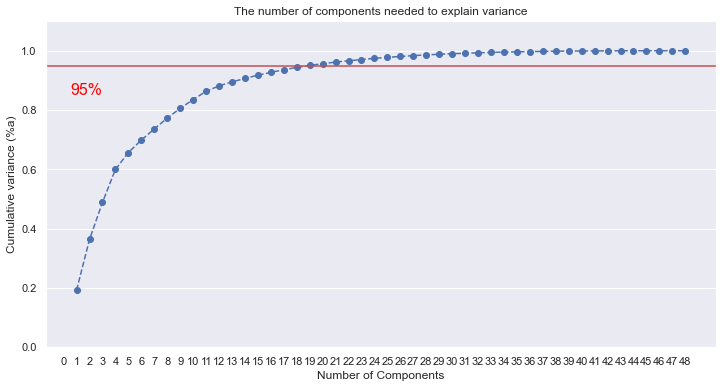

In [119]:
pca = PCA().fit(data_rescaled) # ONLY FITS !

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, df.shape[1]+1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, df.shape[1]+1, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%a)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95%', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [120]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-0.6,0.6)
    plt.ylim(-0.6,0.6)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

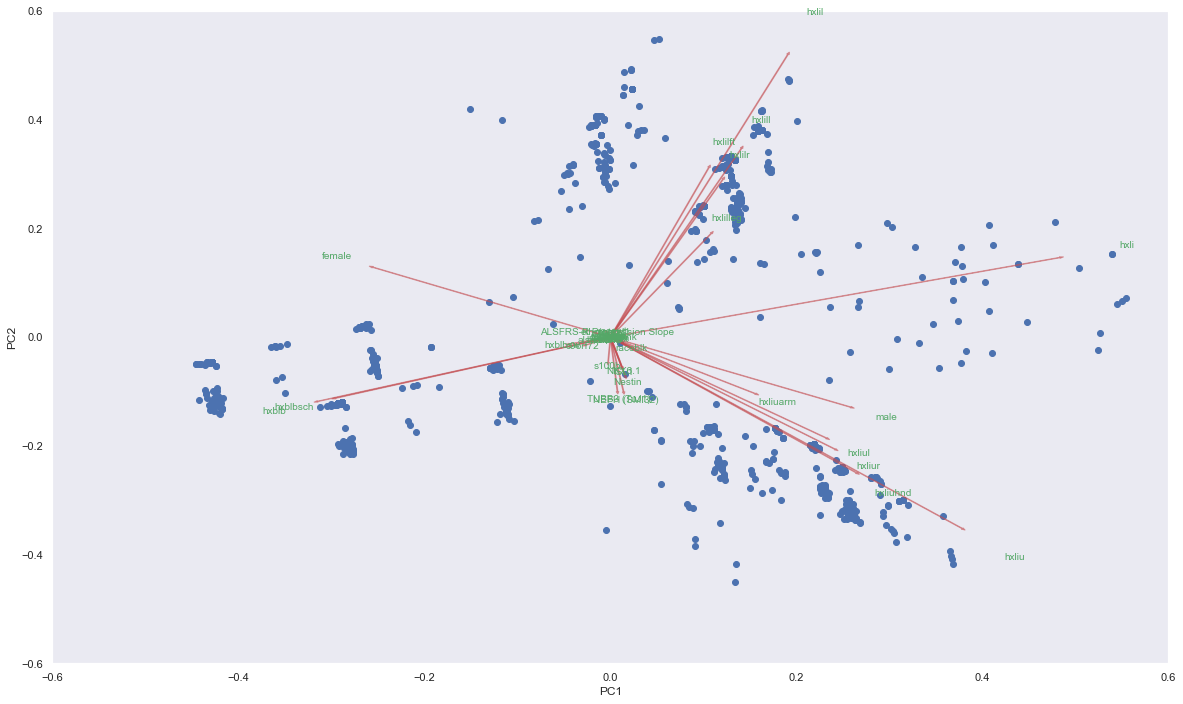

In [124]:
#Call the function. Use only the 2 PCs.
data_pca = pca.transform(data_rescaled) # ONLY TRANSFORM
plt.rcParams["figure.figsize"] = (20,12)
myplot(data_pca[:,0:100],np.transpose(pca.components_[0:3, :]), labels = df.columns)
plt.show()


In [95]:
score = data_pca[:,0:100]

xs = score[:,0]
ys = score[:,1]
zs = score[:,2]

scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())
scalez = 1.0/(zs.max() - zs.min())

fig = px.scatter_3d(x = xs * scalex, y = ys * scaley, z = zs * scalez)

fig.show();

In [122]:
n_eigenv = pca.components_.shape[0] # number of components

### creat a list of array of names of the top 5 most important features for each of the 21 components.
feature_importance_list = [] # list of index in the list of arrays ...
feature_importance_value = [] 

for i in range(n_eigenv):
    a = abs(pca.components_[i])
# Principal axes in feature space, representing the directions of maximum variance in the data.
# Equivalently, the right singular vectors of the centered input data, parallel to its eigenvectors. 
    ind = np.argpartition(a,-2)[-5:]
    ind = ind[np.argsort(-a[ind])]
    feature_importance_list.append(ind)
    feature_importance_value.append(a[ind]) # their values

feature_importance_names = [df.columns[feature_importance_list[i]] for i in range(n_eigenv)]
## put names on place of the values


dic_features = {'Components':range(len(feature_importance_names)),
                'Explained_variance_ratio' : pca.explained_variance_ratio_,
                'Explained_variance' : pca.explained_variance_
               }

names = pd.DataFrame(feature_importance_names)
values = pd.DataFrame(feature_importance_value, columns = [str(i)+'_value' for i in range(feature_importance_value[0].shape[0])])

PCA_res = pd.DataFrame(dic_features).merge(
    names, left_index = True, right_index = True).merge(
    values, left_index = True, right_index = True)
PCA_res

,Components,Explained_variance_ratio,Explained_variance,0,1,2,3,4,0_value,1_value,2_value,3_value,4_value
0,0,1.924605e-01,7.526625e-01,hxli,hxliu,hxblb,hxblbsch,female,0.483036,0.378192,0.314688,0.295536,0.255571
1,1,1.709885e-01,6.686914e-01,hxlil,hxliu,hxlill,hxlilft,hxlilr,0.520267,0.351992,0.347531,0.312498,0.290734
2,2,1.250563e-01,4.890623e-01,TUBB3 (TuJ1),NEFH (SMI32),Nestin,NKX6.1,s100b,0.574429,0.535268,0.338745,0.312214,0.196900
3,3,1.110639e-01,4.343418e-01,male,female,hxliu,hxliuhnd,hxliuarm,0.640363,0.639356,0.203488,0.178877,0.055151
4,4,5.721642e-02,2.237584e-01,hxblb,hxblbsch,hxlilleg,hxlilr,hxliul,0.563247,0.550274,0.247163,0.227029,0.216105
5,5,4.189890e-02,1.638556e-01,alsdied,racewt,hxlilleg,hxliuarm,raceblk,0.630500,0.453380,0.301444,0.209169,0.182784
6,6,3.757662e-02,1.469523e-01,racewt,alsdied,ethnic,hxlilft,hxlilleg,0.688588,0.446084,0.274911,0.259874,0.238744
7,7,3.630184e-02,1.419670e-01,hxliul,hxliur,hxliuarm,hxliuhnd,hxlilr,0.608643,0.497451,0.340519,0.316835,0.283069
8,8,3.325386e-02,1.300471e-01,alsdied,hxlilft,hxlilr,hxblb,racewt,0.576054,0.442369,0.279193,0.131551,0.083750
9,9,2.947551e-02,1.152710e-01,hxlill,hxlilr,hxliur,hxlilft,raceblk,0.589790,0.542950,0.320958,0.268277,0.032576


# Networkiiiiiing

In [ ]:
# NODES ?
# ATTRIBUTES ?

# edges weights ??


# in regard of the PCA results ?? how to i select the features ??
# or while building the network do i don't consider the PCA, to mayber discover clusters ? not seenable by it ?

In [168]:
n_df = table_extended.iloc[:,4:]
n_df = n_df.loc[(n_df != 0).any(axis = 1)] # to drop rows with only 0
n_df = n_df.loc[:, (n_df != 0).any(axis=0)] # to drop columns with only 0
print(n_df.shape)
n_df.head()

(977, 35)


,ang,c9orf72,fus,mutot,setx,sod1,tdp43,vcp,hxax,hxaxnk,hxaxtr,hxaxtrrp,hxblb,hxblbsch,hxblbsw,hxgen,hxli,hxlil,hxlilft,hxlill,hxlilleg,hxlilr,hxliu,hxliuarm,hxliuhnd,hxliul,hxliur,NEFH (SMI32),ISL1,NKX6.1,TUBB3 (TuJ1),s100b,Nestin,trachrsn,pavyn
Participant_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CASE-NEUAA295HHE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,62.9,10.556,31.805,71.380,36.141,45.230,0.0,0.0
CASE-NEUAA599TMX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.1,6.333,29.514,63.153,60.533,0.000,0.0,0.0
CASE-NEUAB000NKC,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.6,1.191,30.105,76.747,2.804,30.693,0.0,0.0
CASE-NEUAC617GR5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0
CASE-NEUAD542VT0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,64.6,13.794,39.716,78.979,37.091,66.382,0.0,0.0


In [230]:
edge = pd.DataFrame(n_df.unstack().loc[lambda x: x != 0].reset_index()) # take the multi index and their values (--> weights)
edge.columns = ['gene','Participant_ID','weight']
edge

,gene,Participant_ID,weight
0,ang,CASE-NEUUJ770WU8,1.0
1,c9orf72,CASE-NEUAB000NKC,1.0
2,c9orf72,CASE-NEUBC175HW2,1.0
3,c9orf72,CASE-NEUBD062TJV,1.0
4,c9orf72,CASE-NEUCE965ZGK,1.0
...,...,...,...
6142,pavyn,CASE-NEUYL149PRF,1.0
6143,pavyn,CASE-NEUYP235ZLD,1.0
6144,pavyn,CASE-NEUYR166GN9,1.0
6145,pavyn,CASE-NEUZE814JZF,1.0


In [169]:
attributes = table_extended.iloc[:,:4]
attributes

,origin,sex,ALSFRS-R Progression Slope,alsdied
Participant_ID,,,,
CASE-NEUAA295HHE,racewt,male,-0.6250,0.0
CASE-NEUAA599TMX,racewt,female,0.0000,1.0
CASE-NEUAB000NKC,racewt,female,-0.5590,1.0
CASE-NEUAC617GR5,raceasn,male,-0.0725,0.0
CASE-NEUAD142RRY,racewt,male,0.0000,1.0
...,...,...,...,...
CTRL-NEUZH755EKF,racewt,male,0.0000,0.0
CTRL-NEUZL045YD3,raceasn,female,0.0000,0.0
CTRL-NEUZR532AA4,racewt,female,0.0000,0.0


In [234]:
np.array(edge) # to give it as 3 tuples list

array([['ang', 'CASE-NEUUJ770WU8', 1.0],
       ['c9orf72', 'CASE-NEUAB000NKC', 1.0],
       ['c9orf72', 'CASE-NEUBC175HW2', 1.0],
       ...,
       ['pavyn', 'CASE-NEUYR166GN9', 1.0],
       ['pavyn', 'CASE-NEUZE814JZF', 1.0],
       ['pavyn', 'CASE-NEUWP426NBR', 1.0]], dtype=object)

In [235]:
B = nx.Graph()

B.add_nodes_from(n_df.index, bipartite=0)
B.add_nodes_from(n_df.columns, bipartite=1)

B.add_weighted_edges_from(np.array(edge))

# I have to add connection between the variables, or the graph will not be connected ?
# is it a problem ? --> doesn't really make sens ...
# for cytoscape don't have to do that
## to build a bipartite graph ...
m_edge = []
for i in range(len(n_df.columns)-1):
    t = (n_df.columns[i],n_df.columns[i+1])
    m_edge.append(t)
#B.add_edges_from(m_edge)

# how to add weight to edges ??

In [236]:
nx.is_connected(B)

True

In [237]:
nx.is_bipartite(B)

True

AttributeError: module 'matplotlib.cbook' has no attribute 'iterable'

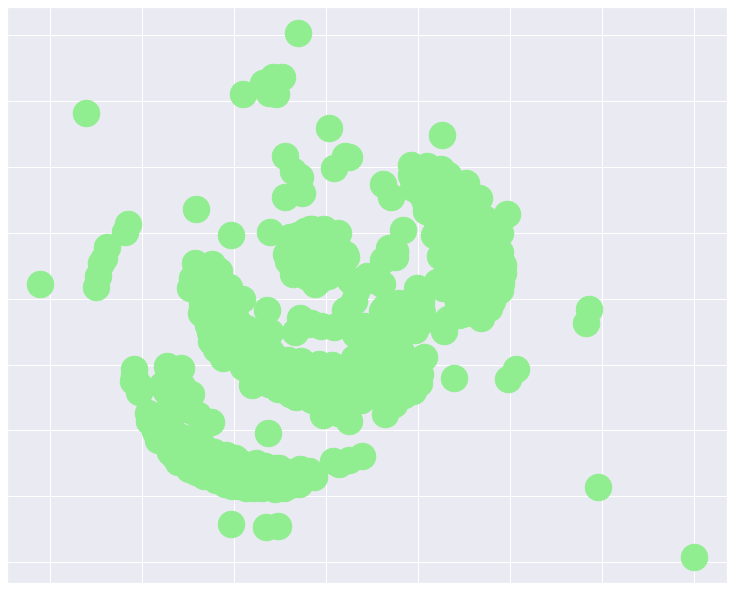

In [238]:
#top = nx.bipartite.sets(B)[0]
#pos = nx.bipartite_layout(B, top)
plt.rcParams['figure.figsize'] = (10 ,8)

nx.draw(B, #pos=pos, 
        node_color='lightgreen', 
        node_size=700,
        with_labels=True)


###  PROJECTION

In [345]:
l=bipartite.weighted_projected_graph(B,n_df.columns)
#nx.draw(l, with_labels=True)
#plt.show()
# https://stackoverflow.com/questions/40211559/to-show-the-weights-of-edges-in-a-projected-network

In [246]:
dic = {l.edges(data = True)}

In [346]:
projected_edges = pd.DataFrame(l.edges(data = True))
projected_edges[2] = projected_edges.iloc[:,2].apply(lambda x: x['weight']) # to extract the weight from the dict
projected_edges

,0,1,2
0,ang,setx,1
1,c9orf72,hxliur,12
2,c9orf72,NKX6.1,30
3,c9orf72,hxaxtr,2
4,c9orf72,ISL1,30
...,...,...,...
452,s100b,Nestin,353
453,s100b,trachrsn,14
454,Nestin,pavyn,15
455,Nestin,trachrsn,14


In [335]:
projected_edges = projected_edges[projected_edges[2] > 6]

In [347]:
print(projected_edges.shape)
projected_edges[2].value_counts()

(457, 3)


1      69
2      31
3      26
8      17
10     17
       ..
98      1
100     1
106     1
118     1
421     1
Name: 2, Length: 101, dtype: int64

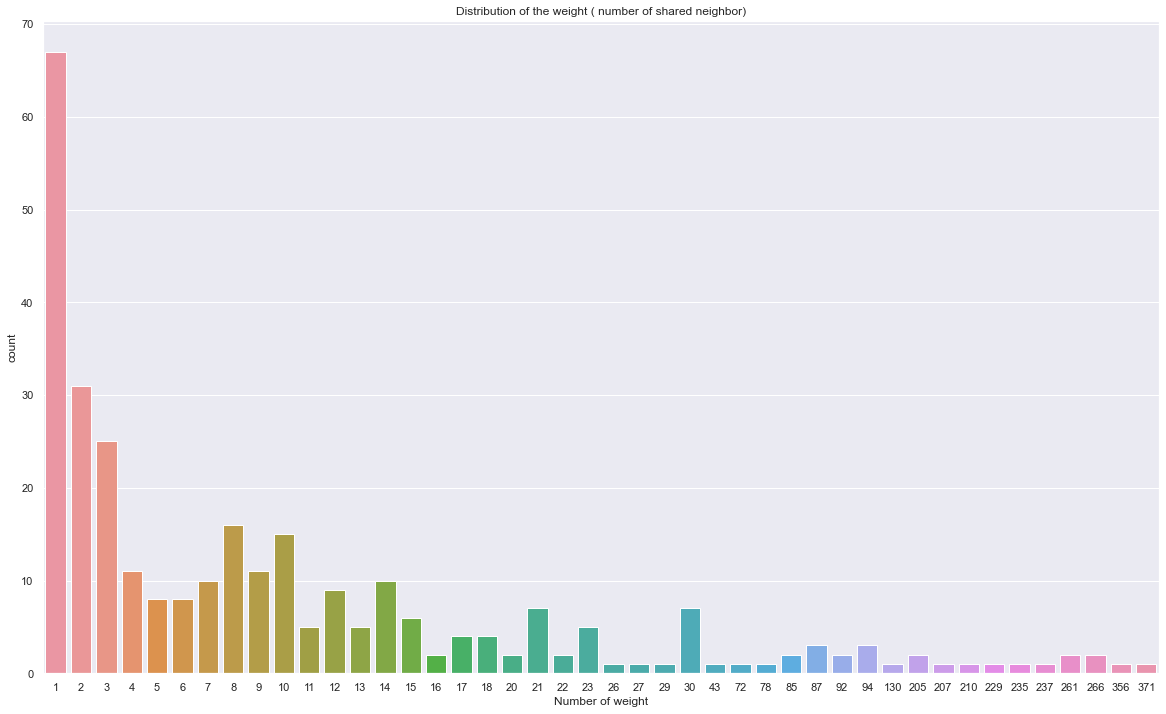

In [361]:
ax = sns.countplot(x = projected_edges[2].iloc[:300])
plt.title("Distribution of the weight ( number of shared neighbor)")
plt.rcParams["figure.figsize"] = (20,12)
plt.xlabel("Number of weight")
plt.show();

## Dataset to cytoscape

In [198]:
attributes.to_csv('attributes_extended_table.csv')

In [229]:
edge.to_csv('edge_extended_table.csv')

In [202]:
table_extended.to_csv('extended_table.csv')

In [203]:
n_df.to_csv('n_df.csv')

In [337]:
projected_edges.to_csv('projected_edges_extended_table.csv')